In [4]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import datasets

In [11]:
(x, y), (x_test, y_test) = datasets.mnist.load_data()
print("x: {}\t y:{}\t x_test:{}\ty_test:{}".format(x.shape, y.shape, x_test.shape, y_test.shape))


x: (60000, 28, 28)	 y:(60000,)	 x_test:(10000, 28, 28)	y_test:(10000,)


In [12]:
# numpy数组必须转化为tensor以后才能被tensorflow提供的各种高级功能
train_db = tf.data.Dataset.from_tensor_slices((x, y))

# 转化为DataSet对象后，通常还需要对原始数据进行一系列的操作，例如标准化，预处理

# 随机打散  buffer_size为缓冲池大小，返回仍然是一个Dataset对象
train_db = train_db.shuffle(10000) 

# 设置batch_size
train_db = train_db.batch(128)

In [15]:
# 预处理函数
def preprocess(x, y):
    # 自动传入x, y 对象。shape 为[b, 28, 28], [b]
    # 标准化像素值到0-1
    x = tf.cast(x, dtype=tf.float32)/255
    # 打平为一维数组
    x = tf.reshape(x, [-1, 28*28])
    # y 处理为整型
    y = tf.cast(y, dtype=tf.int32)
    y = tf.one_hot(y, depth=10)
    
    return x,y

In [16]:
train_db = train_db.map(preprocess)

train_db = train_db.repeat(20)

In [24]:
test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_db = test_db.shuffle(1000).batch(128).map(preprocess)

In [25]:
x, y = next(iter(train_db))
print(x.shape, "\t", y.shape)

(128, 784) 	 (128, 10)


In [35]:

def main():
    # 指标记录
    accs, losses = [], []
    # 学习率
    lr = 0.01
    
    # 权重初始化
    w1, b1 = tf.Variable(tf.random.normal([784, 256], stddev=0.1)), tf.Variable(tf.zeros([256]))
    w2, b2 = tf.Variable(tf.random.normal([256, 128], stddev=0.1)), tf.Variable(tf.zeros([128]))
    w3, b3 = tf.Variable(tf.random.normal([128, 10], stddev=0.1)), tf.Variable(tf.zeros([10]))
    
    # 训练， Dataset类型可以使用 step, (X,y)的形式进行迭代
    for step, (x, y) in enumerate(train_db):
        x = tf.reshape(x, (-1, 784))
        with tf.GradientTape() as tape:
            # 网络结构
            h1 = x @ w1 + b1
            h1 = tf.nn.relu(h1)
            
            h2 = h1@w2 + b2
            h2 = tf.nn.relu(h2)
            
            out = h2@w3 + b3
            
            # loss
            loss = tf.square(y - out)
            loss = tf.reduce_mean(loss)
        
        # 计算各个梯度信息
        grads = tape.gradient(loss, [w1, b1, w2, b2, w3, b3])
        
        # 梯度更新
        for p, g in zip([w1, b1, w2, b2, w3, b3], grads):
            p.assign_sub(lr*g)
        
        # 验证集准确率
        if step % 800 == 0:
            losses.append(float(loss))
            total , total_correct =- 0., 0
            for x, y in test_db:
                h1 = x @ w1 + b1
                h1 = tf.nn.relu(h1)

                h2 = h1@w2 + b2
                h2 = tf.nn.relu(h2)

                out = h2@w3 + b3
                
                pred = tf.argmax(out, axis=1)
                y = tf.argmax(y, axis=1)
                
                correct = tf.equal(pred, y)
                total_correct += tf.reduce_sum(tf.cast(correct, dtype=tf.int32)).numpy()
                total += x.shape[0]
            print(step,"loss:", loss,  "验证集准确率: ", total_correct/total)
            accs.append(total_correct/total)
    return losses, accs
                
    

In [36]:
losses, accs = main()

0 loss: tf.Tensor(0.85535944, shape=(), dtype=float32) 验证集准确率:  0.0789
800 loss: tf.Tensor(0.08140639, shape=(), dtype=float32) 验证集准确率:  0.5987
1600 loss: tf.Tensor(0.064361475, shape=(), dtype=float32) 验证集准确率:  0.702
2400 loss: tf.Tensor(0.056051463, shape=(), dtype=float32) 验证集准确率:  0.7563
3200 loss: tf.Tensor(0.049647518, shape=(), dtype=float32) 验证集准确率:  0.7885
4000 loss: tf.Tensor(0.042791605, shape=(), dtype=float32) 验证集准确率:  0.8116
4800 loss: tf.Tensor(0.04693512, shape=(), dtype=float32) 验证集准确率:  0.8239
5600 loss: tf.Tensor(0.04005591, shape=(), dtype=float32) 验证集准确率:  0.8365
6400 loss: tf.Tensor(0.036599893, shape=(), dtype=float32) 验证集准确率:  0.8457
7200 loss: tf.Tensor(0.03825946, shape=(), dtype=float32) 验证集准确率:  0.8521
8000 loss: tf.Tensor(0.029656097, shape=(), dtype=float32) 验证集准确率:  0.8574
8800 loss: tf.Tensor(0.037333556, shape=(), dtype=float32) 验证集准确率:  0.8629


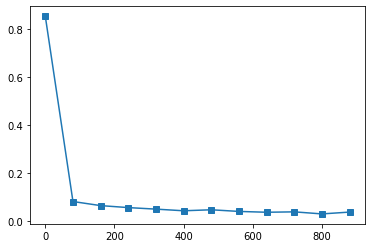

In [37]:
from matplotlib import pyplot as plt
plt.figure()
x = [i*80 for i in range(len(losses))]
plt.plot(x, losses, color='C0', marker='s', label='训练')